<a href="https://colab.research.google.com/github/miljosan/EMG_Prosthesis/blob/main/model/SEN0240_EMGSignals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo CNN para señales EMG

In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import random as rd
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuración de parámetros globales
tamaño_ventana = 300 # Número de muestras por ventana
n_canales = 1 # Número de canales de datos EMG
n_clases = 5 # Número de clases de movimiento

In [ ]:
# Función para cargar datos desde las carpetas
def cargar_datos(carpeta, etiqueta):
    archivos = [os.path.join(carpeta, archivo) for archivo in os.listdir(carpeta) if archivo.endswith('.csv')]
    datos = []
    for archivo in archivos:
        # Try different delimiters
# Try reading with comma delimiter first
        try:
            df = pd.read_csv(archivo, header=None, encoding="latin-1", sep=',')
        except pd.errors.ParserError: # Import and use pd.errors.ParserError
            try:
                df = pd.read_csv(archivo, header=None, encoding="latin-1", sep=';') # Try semicolon
            except pd.errors.ParserError: # Import and use pd.errors.ParserError
                df = pd.read_csv(archivo, header=None, encoding="latin-1", sep='\t') # Try tab

        df = df.iloc[80:].copy()
        # Use .loc for indexing to avoid SettingWithCopyWarning
        df.loc[:, 0] = pd.to_numeric(df.loc[:, 0], errors='coerce')
        df.dropna(inplace=True) # Elimina las filas con valores NaN
        # Check if the DataFrame is empty before assigning labels
        if not df.empty:
            df.loc[:, 'label'] = etiqueta # Agregar la etiqueta
            datos.append(df)
        else:
            print(f"Warning: DataFrame is empty for file: {archivo}. Skipping this file.")
    return pd.concat(datos, ignore_index=True)

# Función para crear ventanas de tiempo
def generar_ventanas(datos, tamaño_ventana, columnas_sensores, solapamiento=0.90):
    ventanas = []
    etiquetas = []
    n_muestras = datos.shape[0]

    paso = int(tamaño_ventana * (1 - solapamiento))  # Paso calculado según el solapamiento

    for i in range(0, n_muestras - tamaño_ventana + 1, paso):
        ventana = datos.iloc[i:i+tamaño_ventana][columnas_sensores].values
        etiqueta = datos.iloc[i:i+tamaño_ventana]['label'].mode()[0]  # Etiqueta más común en la ventana
        ventanas.append(ventana)
        etiquetas.append(etiqueta)

    return np.array(ventanas), np.array(etiquetas)

#Dataset

In [ ]:
# Directorios de las carpetas
tarea_1 = "/content/drive/MyDrive/Tesis/SEN0240/Sujeto1.2/Lento/DERECHO/Descanso"
tarea_2 = "/content/drive/MyDrive/Tesis/SEN0240/Sujeto1.2/Lento/DERECHO/Indice"
tarea_3 = "/content/drive/MyDrive/Tesis/SEN0240/Sujeto1.2/Lento/DERECHO/AnularPinza"
tarea_4 = "/content/drive/MyDrive/Tesis/SEN0240/Sujeto1.2/Lento/DERECHO/Puniocerrado"
tarea_5 = "/content/drive/MyDrive/Tesis/SEN0240/Sujeto1.2/Lento/DERECHO/Anular"


# Cargar datos etiquetados de las carpetas
datos_t1 = cargar_datos(tarea_1, 0) # Etiqueta 0
print(datos_t1)
datos_t2 = cargar_datos(tarea_2, 1) # Etiqueta 1
print(datos_t2)
datos_t3 = cargar_datos(tarea_3, 2) # Etiqueta 2
print(datos_t3)
datos_t4 = cargar_datos(tarea_4, 3) # Etiqueta 3
print(datos_t4)
datos_t5 = cargar_datos(tarea_5, 4) # Etiqueta 4
print(datos_t5)

# Combinar datos de todas las carpetas
datos = pd.concat([datos_t1, datos_t2, datos_t3, datos_t4, datos_t5], ignore_index=True)
if datos.empty:
    print("Error: The combined DataFrame 'datos' is empty. Check data loading.")
else:
    columnas_sensores = datos.columns[:-1]  # Todas las columnas menos la columna "label"
print(datos)

# Generar ventanas de datos
X, y = generar_ventanas(datos, tamaño_ventana, columnas_sensores)
X = X.reshape(-1, tamaño_ventana, n_canales)  # Reshape para añadir dimensión de canal
y = to_categorical(y, num_classes=n_clases)  # One-hot encoding de las etiquetas

       0  label
0      0      0
1      0      0
2      0      0
3      0      0
4      0      0
...   ..    ...
21239  0      0
21240  0      0
21241  0      0
21242  0      0
21243  0      0

[21244 rows x 2 columns]
         0  label
0        0      1
1      529      1
2      576      1
3      169      1
4        0      1
...    ...    ...
16972    0      1
16973    0      1
16974    0      1
16975    0      1
16976    0      1

[16977 rows x 2 columns]
          0  label
0         0      2
1         0      2
2      1600      2
3       225      2
4       484      2
...     ...    ...
17995  4624      2
17996  2601      2
17997     0      2
17998     0      2
17999  3721      2

[18000 rows x 2 columns]
         0  label
0        0      3
1        0      3
2        0      3
3        0      3
4        0      3
...    ...    ...
21995  121      3
21996    0      3
21997    0      3
21998    0      3
21999    0      3

[22000 rows x 2 columns]
          0  label
0       625      4
1     

In [ ]:
# Fijar semillas
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
rd.seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Dividir datos en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")
print(X_train[0])
print(y_train[0])

Tamaño del conjunto de entrenamiento: (2332, 300, 1)
Tamaño del conjunto de validación: (500, 300, 1)
Tamaño del conjunto de prueba: (500, 300, 1)
[[289]
 [0]
 [576]
 [0]
 [0]
 [0]
 [144]
 [0]
 [0]
 [196]
 [225]
 [0]
 [0]
 [0]
 [0]
 [0]
 [169]
 [0]
 [196]
 [0]
 [625]
 [121]
 [729]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [169]
 [225]
 [0]
 [0]
 [0]
 [529]
 [0]
 [2401]
 [729]
 [169]
 [324]
 [0]
 [0]
 [0]
 [1521]
 [361]
 [961]
 [1089]
 [225]
 [196]
 [529]
 [529]
 [0]
 [1024]
 [441]
 [0]
 [0]
 [0]
 [121]
 [0]
 [529]
 [0]
 [289]
 [0]
 [1156]
 [0]
 [1296]
 [121]
 [0]
 [0]
 [0]
 [196]
 [196]
 [1156]
 [4225]
 [0]
 [1296]
 [0]
 [289]
 [0]
 [441]
 [169]
 [0]
 [324]
 [144]
 [324]
 [289]
 [0]
 [169]
 [361]
 [0]
 [121]
 [256]
 [169]
 [441]
 [484]
 [0]
 [196]
 [0]
 [0]
 [0]
 [0]
 [0]
 [289]
 [576]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [121]
 [0]
 [0]
 [0]
 [0]
 [121]
 [0]
 [0]
 [400]
 [0]
 [0]
 [0]
 [1444]
 [625]
 [196]
 [144]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [121]
 [324]
 [0]
 [0]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


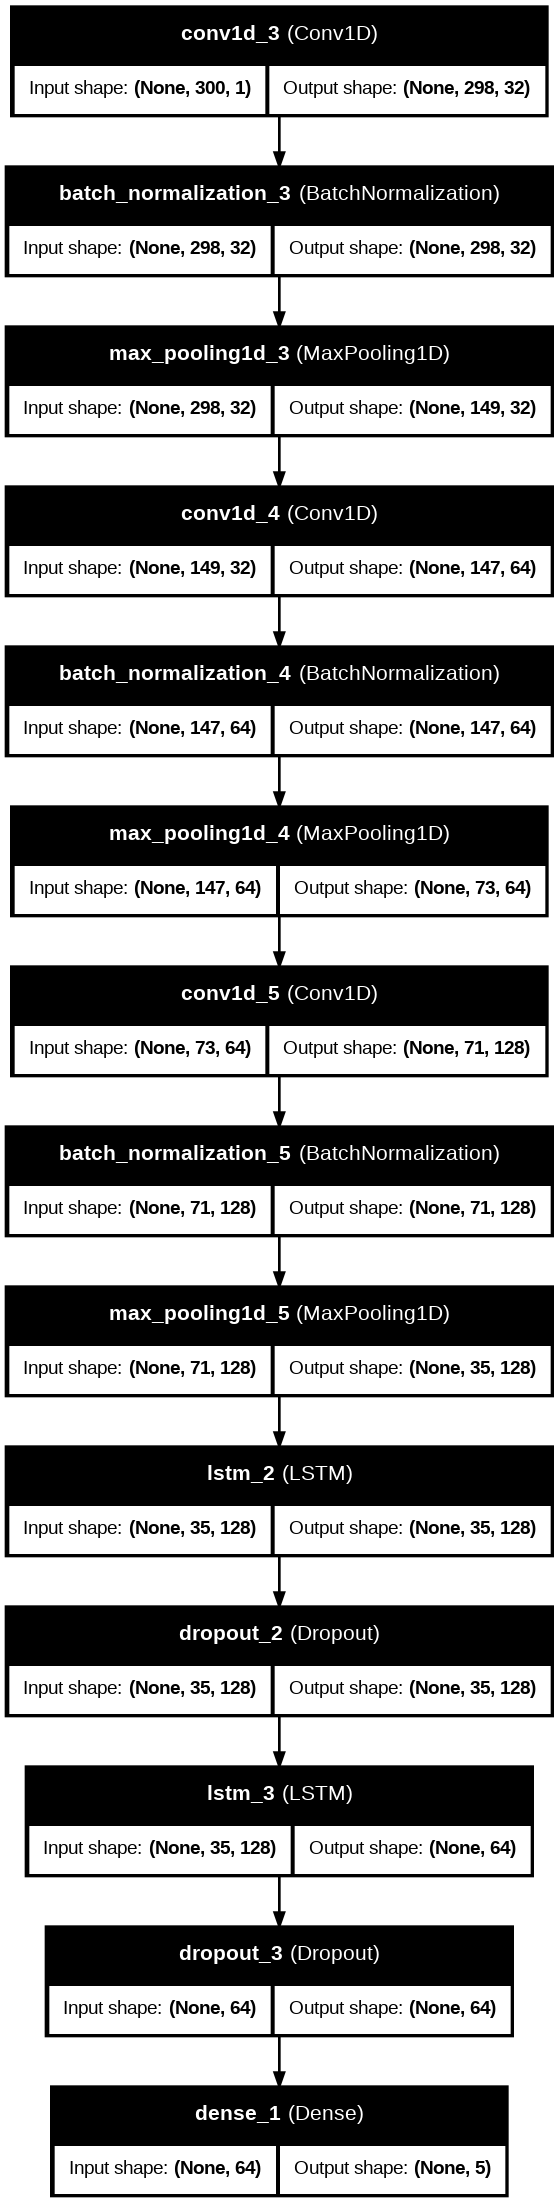

In [ ]:
# Crear el modelo CNN + LSTM optimizado
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(tamaño_ventana, n_canales)),
    BatchNormalization(),  # Normalización
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),  # Normalización
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),  # Normalización
    MaxPooling1D(pool_size=2),
    LSTM(128, activation='tanh', return_sequences=True),  # LSTM 1
    Dropout(0.4),
    LSTM(64, activation='tanh', return_sequences=False),  # LSTM 2
    Dropout(0.4),
    Dense(n_clases, activation='softmax')
])

# Graficar el modelo
from tensorflow.keras.utils import plot_model
plot_model(model,
           to_file='modelo_cnn_lstm.png',
           show_shapes=True,
           show_layer_names=True,
           dpi=96)


In [ ]:
# Ajustar el optimizador con el mejor learning rate
optimizer = Adam(learning_rate=0.0005)

# Compilar el modelo
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("mejor_modelo_emg_optimizado_v1_1.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)


# Calculate class weights using argmax to get class indices
class_weights = compute_class_weight(class_weight='balanced',
                                        classes=np.unique(np.argmax(y_train, axis=1)),
                                        y=np.argmax(y_train, axis=1))
# Convert class weights to a dictionary for Keras
class_weight_dict = dict(enumerate(class_weights))

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int32')
y_val = y_val.astype('int32')
y_test = y_test.astype('int32')

# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[checkpoint, reduce_lr],
    class_weight=class_weight_dict
)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión final en el conjunto de prueba: {accuracy * 100:.2f}%")

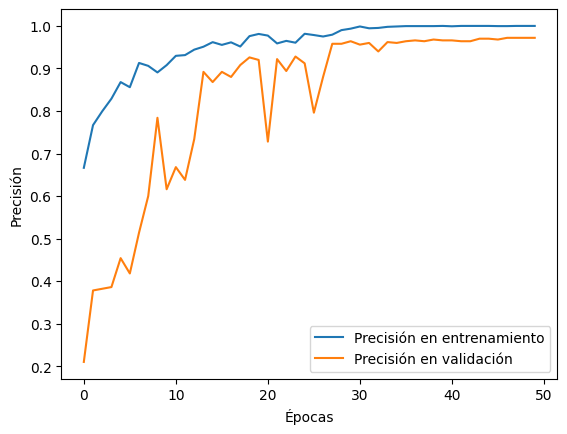

In [ ]:
#Visualización de accuracy
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

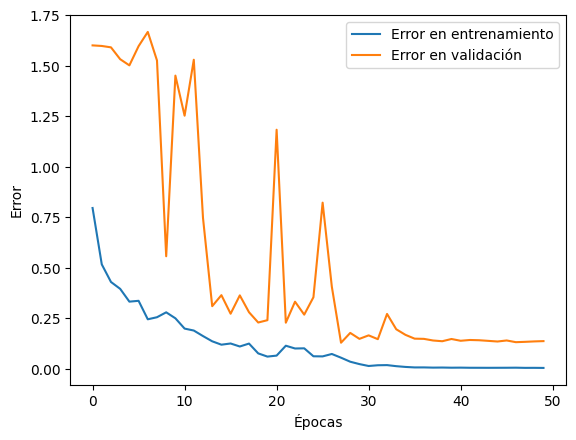

In [ ]:
#Visualización de pérdidas
plt.plot(history.history['loss'], label='Error en entrenamiento')
plt.plot(history.history['val_loss'], label='Error en validación')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


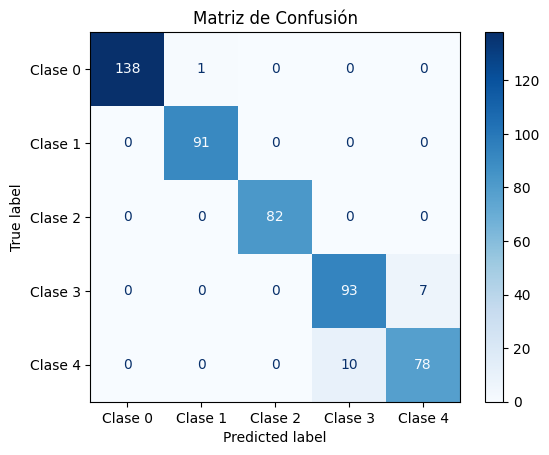

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       139
           1       0.99      1.00      0.99        91
           2       1.00      1.00      1.00        82
           3       0.90      0.93      0.92       100
           4       0.92      0.89      0.90        88

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500


Matriz de confusión
[[138   1   0   0   0]
 [  0  91   0   0   0]
 [  0   0  82   0   0]
 [  0   0   0  93   7]
 [  0   0   0  10  78]]


In [ ]:
# Matriz de confusión
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Get the unique class labels from y_true
unique_classes = np.unique(y_true)

# Generate labels based on the unique classes
etiquetas = [f'Clase {i}' for i in unique_classes]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etiquetas)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred))
print("")
print("Matriz de confusión")
print(cm)

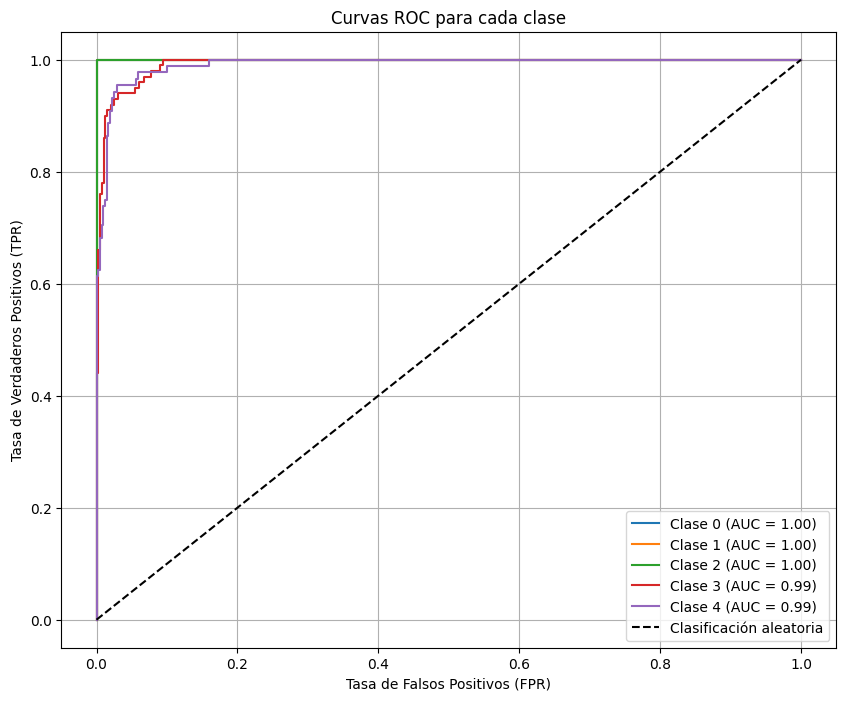

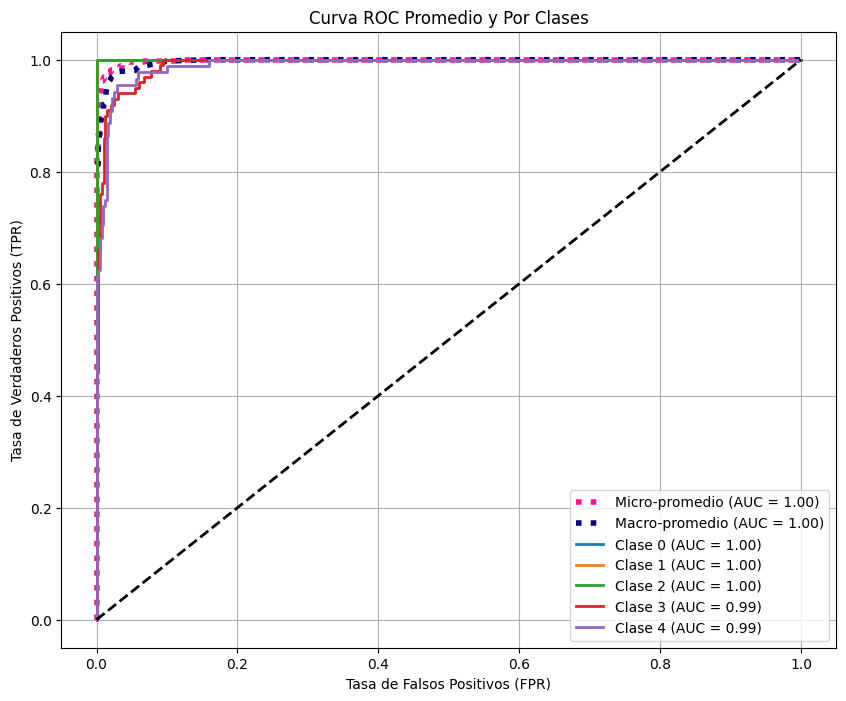

In [ ]:
# Graficar ROC y calcular AUC para cada clase
n_clases = y_test.shape[1]  # Número de clases
fpr = {}  # Tasa de falsos positivos para cada clase
tpr = {}  # Tasa de verdaderos positivos para cada clase
roc_auc = {}  # Área bajo la curva para cada clase

# Calcular ROC y AUC para cada clase
for i in range(n_clases):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(n_clases):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Añadir línea diagonal (clasificación aleatoria)
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación aleatoria')

# Configuración del gráfico
plt.title('Curvas ROC para cada clase')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calcular y graficar la curva ROC promedio (micro y macro promedios)
from sklearn.metrics import roc_auc_score

# Curva micro-promedio
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calcular el AUC macro-promedio
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_clases)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_clases):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_clases

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar curva ROC promedio
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-promedio (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-promedio (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)

# Curvas individuales
for i in range(n_clases):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Configuración del gráfico
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Curva ROC Promedio y Por Clases')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
